### Working environment
>1. tensorflow 1.13.1
>2. Python 3.6
### Dataset:
> ISIC 2018: skin cancer images

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from attention_unet import *
from deeplab_model import *
from data_pipeline import *
from post_eval import mIOU, do_crf
import numpy as np
import os as os

# Select single gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
#config = tf.ConfigProto()
# Select multi gpu
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 1.0
sess=tf.Session(config = config)

# Running with CPU
#config = tf.ConfigProto()
#config.intra_op_parallelism_threads = 44
#config.inter_op_parallelism_threads = 44
#tf.Session(config=config)


### Build and compile models 

In [3]:
tf.keras.backend.clear_session()
np.random.seed(609)
tf.set_random_seed(610)

train_test_ratio = 0.8
num_classes = 1
batch_size = 12
initial_epoch = 0
epochs = 10
init_lr = 2e-4
min_lr = 1e-7

loss = 'crossentropy'
metrics = ['jaccard_index',
           'pixelwise_sensitivity',
           'pixelwise_specificity']

# Make model


deeplab_model = Deeplabv3(metrics = metrics, loss=loss, lr= init_lr)
compile_model(deeplab_model, num_classes, metrics, loss, init_lr)


#deeplab_subpixel = deeplab_subpixel_method(metrics = metrics, loss=loss, lr=init_lr)    
#compile_model(deeplab_subpixel, num_classes, metrics, loss, init_lr)

# Attention U-Net

#att_unetmodel = attention_gating_unet2D(loss=loss, lr=init_lr ,metrics= metrics, num_classes=1, num_gpu=4)
#compile_model(att_unetmodel, num_classes, metrics, loss, init_lr)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Split dataset and make data generator

In [4]:
# Make input generator
# make train-test split - set 8:2 split (return: data_path list)
imgs_train, label_train, imgs_test, label_test = split_datalist()

train_generator = create_generators(batch_size=batch_size, image_path=imgs_train, label_path=label_train,
                                    blur = 0, crop_shape = None, n_classes = 1,
                                    horizontal_flip = True, vertical_flip = True, brightness=0.1, 
                                    rotation=True, zoom=0.2, seed = 610, do_ahisteq = False)

valid_generator = create_generators(batch_size=batch_size, image_path=imgs_test, label_path=label_test,
                                    blur = 0, crop_shape = None, n_classes = 1, 
                                    horizontal_flip = False, vertical_flip = False, brightness= .0,
                                    rotation=False, zoom= 0., seed = 611, do_ahisteq = False)

#test_imgs, test_labs = load_resize_data(imgs_test, label_test)

In [5]:
def build_callbacks(tf_board = False):
    #checkpointer = ModelCheckpoint(filepath = '../Dir', verbose=1, save_best_only=True, save_weights_only=True,
    #                               monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, verbose=1, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor= 1-(1/np.exp(1)),
                                                     patience=2,
                                                     verbose=1,
                                                     mode='auto',
                                                     min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = False)

### Training model

In [6]:
train_with_generator(model=deeplab_model, epochs=15, train_generator=train_generator,
                     valid_generator= valid_generator, callbacks= callbacks, mp = False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
172/172 [==============================] - 150s 874ms/step - loss: 2.3651 - binary_jaccard_index: 0.7073 - binary_pixelwise_sensitivity: 0.8271 - binary_pixelwise_specificity: 0.8874 - val_loss: 6.7613 - val_binary_jaccard_index: 0.6921 - val_binary_pixelwise_sensitivity: 0.9293 - val_binary_pixelwise_specificity: 0.8746
Epoch 2/15
172/172 [==============================] - 132s 765ms/step - loss: 1.4078 - binary_jaccard_index: 0.7974 - binary_pixelwise_sensitivity: 0.8626 - binary_pixelwise_specificity: 0.9434 - val_loss: 2.0505 - val_binary_jaccard_index: 0.7769 - val_binary_pixelwise_sensitivity: 0.8199 - val_binary_pixelwise_specificity: 0.9770
Epoch 3/15
172/172 [==============================] - 135s 783ms/step - loss: 1.4311 - binary_jaccard_index: 0.7907 - binary_pixelwise_sensitivity: 0.8555 - binary_pixelwise_specificity: 0.9450 - val_loss: 2.3588 - val_binary_jaccard_index: 0.7712 - val_binary_pixelwise_sensitivity: 

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# read test image
pred_img = cv2.imread(imgs_test[2])
pred_img = cv2.resize(pred_img, (224,224))
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

# generate test segmentation
pred = deeplab_model.predict(np.expand_dims(pred_img, axis=0))
pred = np.squeeze(pred)
# Thresholding
pred_threshold = (pred > 0.5).astype(np.int8)
MAP = do_crf(pred_img, pred_threshold.astype('int32'), zero_unsure=False)

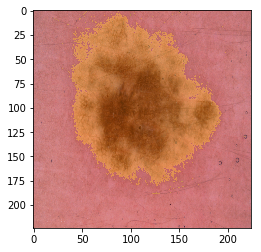

In [27]:
plt.imshow(pred_img)
plt.imshow(MAP, alpha=0.2)

In [32]:
pred_lab1 = cv2.imread(label_test[2])
pred_lab2 = cv2.resize(pred_lab1, (224,224))
pred_lab = cv2.resize(pred_threshold.astype(np.uint8), (pred_lab1.shape[1], pred_lab1.shape[0]))

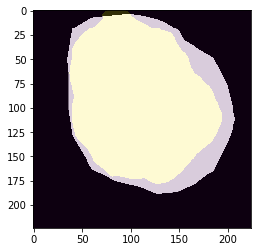

In [33]:
plt.imshow(pred_lab2)
plt.imshow(pred_threshold, alpha=0.2)

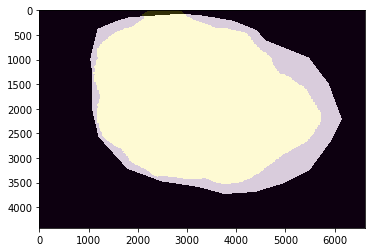

In [34]:
plt.imshow(pred_lab1)
plt.imshow(pred_lab, alpha=0.2)

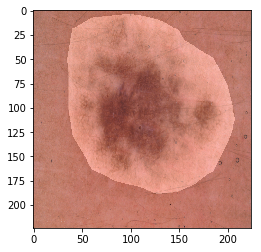

In [36]:
plt.imshow(pred_img)
plt.imshow(pred_lab2, alpha=0.)